<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/09_few-to-no-labels-with-faiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

**이 노트북은 9장 '임베딩을 룩업 테이블로 사용하기' 절의 코드를 담고 있습니다.**

In [1]:
# 최신 라이브러리를 설치합니다.
!pip install transformers datasets faiss-cpu scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.9 MB/s 
     |████████████████████████████████| 365 kB 71.3 MB/s 
     |████████████████████████████████| 8.6 MB 30.4 MB/s 
     |████████████████████████████████| 89 kB 8.2 MB/s 
     |████████████████████████████████| 6.6 MB 52.5 MB/s 
     |████████████████████████████████| 120 kB 59.3 MB/s 
     |████████████████████████████████| 115 kB 53.7 MB/s 
     |████████████████████████████████| 212 kB 51.1 MB/s 
     |████████████████████████████████| 127 kB 58.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
# 필요한 패키지를 임포트합니다.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

데이터를 다운로드합니다.

In [3]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)

레이블 열을 레이블 이름의 리스트로 바꿉니다.



In [4]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


 레이블 열을 필터링합니다.

In [5]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

레이블 열을 확장합니다.

In [6]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


레이블링 여부를 기록한 `split` 열을 만듭니다.

In [7]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


제목과 본문을 합칩니다.

In [8]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

중복 이슈를 삭제합니다.

In [9]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"삭제된 중복 이슈: {(len_before-len(df_issues))/len_before:.2%}")

삭제된 중복 이슈: 1.88%


훈련 세트를 만듭니다.

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])

MultiLabelBinarizer()

In [11]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, 
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [12]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [13]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

훈련 슬라이스를 만듭니다.

In [14]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # 다음 슬라이스 크기를 채우는데 필요한 샘플을 분할합니다
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# 코랩의 경우 메모리 부족을 피하기 위해 마지막 슬라이스를 추가하지 않습니다.
# 전체 데이터셋을 마지막 슬라이스로 추가합니다
# train_slices.append(all_indices), train_samples.append(len(ds["train"]))

train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

`label_ids` 열을 만듭니다.

In [15]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

결과를 저장할 딕셔너리를 만듭니다.

In [16]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

그래프 출력 함수를 정의합니다.

In [17]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, 
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, 
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

### 임베딩을 룩업 테이블로 사용하기

In [18]:
import torch
from transformers import AutoTokenizer, AutoModel

# 코랩의 경우 메모리 부족을 피하기 위해 gpt2-medium을 사용합니다.
model_ckpt = "miguelvictor/python-gpt2-medium"
# model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # 토큰 임베딩 추출하기
    token_embeddings = model_output[0]
    # 어텐션 마스크 계산하기
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # 임베딩을 더하지만 마스킹된 토큰은 무시합니다
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # 하나의 벡터로 평균을 반환합니다
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

Some weights of the model checkpoint at miguelvictor/python-gpt2-medium were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [20]:
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

In [21]:
i, k = 0, 3     # 첫 번째 쿼리와 3개의 최근접 이웃을 선택합니다
rn, nl = "\r\n\r\n", "\n"   # 간결한 출력을 위해 텍스트에서 줄바꿈 문자를 삭제합니다

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"쿼리 레이블: {embs_valid[i]['labels']}")
print(f"쿼리 텍스트:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"추출된 문서:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"텍스트:\n{text[:200].replace(rn, nl)} [...]")
    print(f"점수: {score:.2f}")
    print(f"레이블: {label}")

쿼리 레이블: ['new model']
쿼리 텍스트:
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and [...]

추출된 문서:
텍스트:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based models with sign [...]
점수: 32.11
레이블: ['new model']
텍스트:
Add support for DeBERTa

# 🌟 New model addition
## Model description
DeBERTa (Decoding-enhanced BERT with disentangled attention) is a new model architecture:
>  In this paper we propose a ne [...]
점수: 32.78
레이블: ['new model']
텍스트:
Add new CANINE model

# 🌟 New model addition
## Model description
Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architectu [...]
점수: 33.22
레이블: ['new model']


In [22]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [23]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

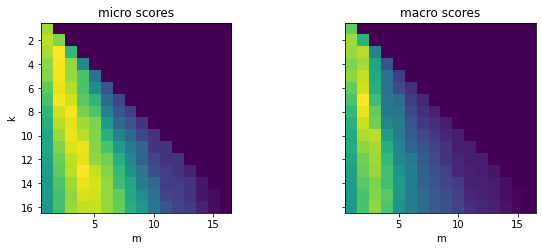

In [24]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [25]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"최상의 k: {k}, 최상의 m: {m}")

최상의 k: 3, 최상의 m: 2


In [26]:
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # 훈련 슬라이스로부터 FAISS 인덱스를 만듭니다
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # 검증 세트로 최상의 k, m 값을 구합니다
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # 테스트 세트에서 예측을 만듭니다
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # 예측을 평가합니다
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

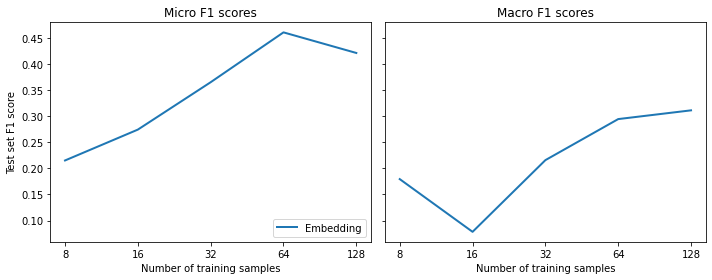

In [27]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

결과를 저장합니다.

In [28]:
import joblib

joblib.dump({'micro': micro_scores, 'macro': macro_scores}, '09_results_of_faiss.gz')

['09_results_of_faiss.gz']